In [ ]:
import pandas as pd
from Bio import SeqIO
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import tight_layout

from sklearn.preprocessing import MultiLabelBinarizer

from pymmseqs.commands import easy_cluster
import os
import re

# Toxins
(taxonomy_id:33208) AND (cc_tissue_specificity:venom) AND (reviewed:true) AND (keyword:KW-0800) AND (fragment:false)

In [ ]:
tox = pd.read_csv('../data/raw/tox.tsv', sep='\t')
tox = tox.dropna(subset=["Protein families"])

tox

In [ ]:
tox['Protein families'] = tox['Protein families'].str.split(',').str[0]
tox['Protein families'] = tox['Protein families'].str.split(';').str[0]

In [ ]:
tox['Protein families'] = tox['Protein families'].replace('I1 superfamily', 'Conotoxin I1 superfamily')
tox['Protein families'] = tox['Protein families'].replace('O1 superfamily', 'Conotoxin O1 superfamily')
tox['Protein families'] = tox['Protein families'].replace('O2 superfamily', 'Conotoxin O2 superfamily')
tox['Protein families'] = tox['Protein families'].replace('E superfamily', 'Conotoxin E superfamily')
tox['Protein families'] = tox['Protein families'].replace('F superfamily', 'Conotoxin F superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin M family', 'Conotoxin M superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin B2 family', 'Conotoxin B2 superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin O1 family', 'Conotoxin O1 superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin O2 family', 'Conotoxin O2 superfamily')

In [ ]:
mapping = {
    r'Conotoxin.*': 'Conotoxin family',
    r'Neurotoxin.*': 'Neurotoxin family',
    r'Scoloptoxin.*|Scolopendra.*': 'Scoloptoxin family',
    r'Caterpillar.*': 'Caterpillar family',
    r'Teretoxin.*': 'Teretoxin family',
    r'Limacoditoxin.*': 'Limacoditoxin family',
    r'Scutigerotoxin.*': 'Scutigerotoxin family',
    r'Cationic peptide.*': 'Cationic peptide family',
    r'Formicidae venom.*': 'Formicidae venom family',
    r'Bradykinin-potentiating peptide family|Natriuretic peptide family': 'Natriuretic, Bradykinin potentiating peptide family',
    r'.*phospholipase.*|.*Phospholipase.*': 'Phospholipase family'
}

# Apply mapping
for pattern, replacement in mapping.items():
    tox['Protein families'] = tox['Protein families'].str.replace(pattern, replacement, regex=True)

# everything with less than 3 samples is "other"
tox["Protein families"] = tox["Protein families"].where(tox["Protein families"].map(tox["Protein families"].value_counts()) >= 3, "other")

tox['Protein families'].value_counts()

# Non-Toxins
(taxonomy_id:33208) AND (reviewed:true) AND (fragment:false) NOT (keyword:KW-0800) AND ((existence:1) OR (existence:2))

In [ ]:
nontox = pd.read_csv('../data/raw/nontox.tsv', sep='\t')
nontox

### Fasta Generation

In [ ]:
def write_fasta(df, filename):
    """Writes a DataFrame to a FASTA file."""
    with open(filename, "w") as f:
        for _, row in df.iterrows():
            f.write(f">{row['Entry']}\n{row['Sequence']}\n")

write_fasta(tox, "../data/raw/tox.fasta")
write_fasta(nontox, "../data/raw/nontox.fasta")

## Remove SPs

In [ ]:
!signalp6 --fastafile ../data/raw/tox.fasta --output_dir ../data/sp6/tox/ --organism eukarya --mode fast --model_dir /Users/selin/Desktop/Uni/signalp6/signalp-6-package/models/

In [ ]:
!signalp6 --fastafile ../data/nontox.fasta --output_dir ../data/sp6/nontox/ --organism eukarya --mode fast --model_dir /Users/selin/Desktop/Uni/signalp6/signalp-6-package/models/

In [ ]:
def fasta_to_dataframe(fasta_file):
    records = SeqIO.parse(fasta_file, "fasta")
    data = []

    for record in records:
        id_part = record.id.split('|')[-1]
        data.append({"identifier": id_part, "Sequence": str(record.seq)})

    df = pd.DataFrame(data)
    return df

# SignalP6 all (processed) sequences
proc_tox = fasta_to_dataframe("../data/sp6/tox/processed_entries.fasta")
proc_nontox = fasta_to_dataframe("../data/sp6/nontox/processed_entries.fasta")
#proc_tox = proc_tox.rename(columns={'Sequence': 'Sequence'})
#proc

In [ ]:
proc_tox

In [ ]:
gff3_tox = pd.read_csv('../data/sp6/tox/output.gff3', sep='\t', comment='#', header=None)
gff3_nontox = pd.read_csv('../data/sp6/nontox/output.gff3', sep='\t', comment='#', header=None)

cols = [
    'identifier', 'source', 'feature_type', 'start', 'end',
    'score', 'strand', 'phase', 'attributes'
]
gff3_tox.columns = cols
gff3_nontox.columns = cols

def extract_seqid(full_seqid):
    return full_seqid.split('|')[-1].split(' ')[0]

gff3_tox['identifier'] = gff3_tox['identifier'].apply(extract_seqid)
gff3_nontox['identifier'] = gff3_nontox['identifier'].apply(extract_seqid)

gff3_tox = pd.merge(gff3_tox, proc_tox, on='identifier')
gff3_nontox = pd.merge(gff3_nontox, proc_nontox, on='identifier')

In [ ]:
gff3_tox[gff3_tox['score'] < 0.8]

### merge with SP6 predictions

In [ ]:
# Merge with tox, replacing 'Sequence' where Entry matches

filtered = gff3_tox[gff3_tox['score'] > 0.8][['identifier', 'Sequence']]
filtered = filtered.rename(columns={'identifier': 'Entry'})
tox.update(filtered.set_index('Entry'))

filtered = gff3_nontox[gff3_nontox['score'] > 0.8][['identifier', 'Sequence']]
filtered = filtered.rename(columns={'identifier': 'Entry'})
nontox.update(filtered.set_index('Entry'))

In [ ]:
write_fasta(tox, "../data/interm/tox_noSP.fasta")
write_fasta(nontox, "../data/interm/nontox_noSP.fasta")

## Clustering
### run mmseqs2 90% sequence similarity clustering per protein family

In [ ]:
out_dir = "../data/families/"
os.makedirs(out_dir, exist_ok=True)

def sanitize_filename(name):
    return re.sub(r"[^a-zA-Z0-9_-]", "_", name)

failed = []

for family, group in tox.groupby("Protein families"):
    safe_family = sanitize_filename(family)

    fasta_path = os.path.join(out_dir, f"{safe_family}.fasta")
    write_fasta(group, fasta_path)

    # Create family-specific mmseqs directory
    family_mmseqs_dir = os.path.join("/Users/selin/PycharmProjects/ToxFam/data/mmseqs", safe_family)
    os.makedirs(family_mmseqs_dir, exist_ok=True)

    cluster_prefix = os.path.join(family_mmseqs_dir, "cluster")
    tmp_dir = os.path.join(family_mmseqs_dir, "tmp")
    os.makedirs(tmp_dir, exist_ok=True)

    try:
        easy_cluster(
            fasta_files=fasta_path,
            cluster_prefix=cluster_prefix,
            tmp_dir=tmp_dir,
            min_seq_id=0.9
        )
    except Exception as e:
        print(f"⚠️ Skipping {safe_family} due to error: {e}")
        failed.append((fasta_path, cluster_prefix, tmp_dir))

# Print mmseqs commands for failures
if failed:
    print("\n🔁 Manual mmseqs2 commands for failed entries:\n")
    for fasta, out, tmp in failed:
        print(f"mmseqs easy-cluster {fasta} {out} {tmp} --min-seq-id 0.9")

In [ ]:
mmseqs_base_dir = "/Users/selin/PycharmProjects/ToxFam/data/mmseqs"
rep_seqs = []

# Go through each family subdirectory
for family_dir in os.listdir(mmseqs_base_dir):
    full_path = os.path.join(mmseqs_base_dir, family_dir)
    if not os.path.isdir(full_path):
        continue

    rep_fasta = os.path.join(full_path, "cluster_rep_seq.fasta")
    if not os.path.exists(rep_fasta):
        continue

    # Parse FASTA and collect entries
    for record in SeqIO.parse(rep_fasta, "fasta"):
        rep_seqs.append({
            "Entry": record.id,
            "Sequence": str(record.seq),
        })

# Create DataFrame
rep_df = pd.DataFrame(rep_seqs).merge(tox[["Entry", "Protein families"]], on="Entry", how="left")
rep_df

In [ ]:
rep_df["Protein families"] = rep_df["Protein families"].where(rep_df["Protein families"].map(rep_df["Protein families"].value_counts()) >= 3, "other")
rep_df["Protein families"].value_counts()

### Train-Val-Test sets with 70:15:15 split

In [ ]:
# Ensure 'Protein families' is split only if not already a list
rep_df['Protein families'] = rep_df['Protein families'].apply(lambda x: x.split(',') if isinstance(x, str) else x)

# Create binary indicator matrix
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(rep_df['Protein families'])

# Save label classes (optional)
label_classes = mlb.classes_

# Train+val vs test split (test=15%)
msss1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
idx_train_val, idx_test = next(msss1.split(rep_df, y))

rep_df_train_val = rep_df.iloc[idx_train_val].copy()  # add .copy() here
y_train_val = y[idx_train_val]

# Train vs val split (val = 15% / (1-0.15) ~0.176 of train_val)
val_size = 0.15 / (1 - 0.15)
msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
idx_train, idx_val = next(msss2.split(rep_df_train_val, y_train_val))

train_df = rep_df_train_val.iloc[idx_train].copy()  # add .copy() here
val_df = rep_df_train_val.iloc[idx_val].copy()      # add .copy() here
test_df = rep_df.iloc[idx_test].copy()              # add .copy() here

# Join lists back to strings with .loc
train_df.loc[:, 'Protein families'] = train_df['Protein families'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)
val_df.loc[:, 'Protein families'] = val_df['Protein families'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)
test_df.loc[:, 'Protein families'] = test_df['Protein families'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

In [ ]:
def print_split_sizes(train_df, val_df, test_df, total_df):
    print(f"Train size: {len(train_df)} ({len(train_df)/len(total_df)*100:.2f}%)")
    print(f"Validation size: {len(val_df)} ({len(val_df)/len(total_df)*100:.2f}%)")
    print(f"Test size: {len(test_df)} ({len(test_df)/len(total_df)*100:.2f}%)")
print_split_sizes(train_df, val_df, test_df, rep_df)

/var/folders/6k/gr_1_h_97154rq71pm_q3jn40000gn/T/ipykernel_6741/2101714188.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', num_colors)


<Figure size 3000x2100 with 0 Axes>

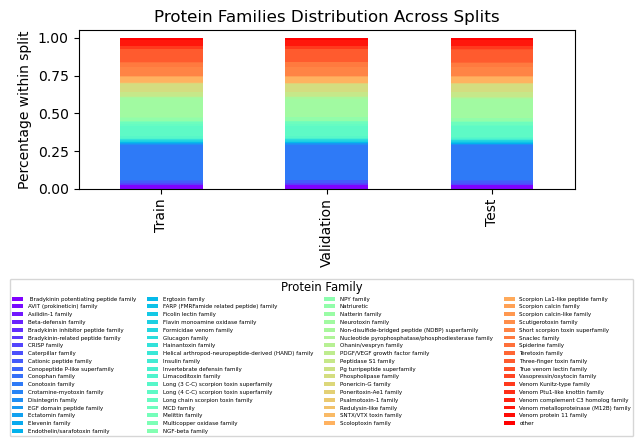

In [125]:
def plot_protein_family_distribution(train_df, val_df, test_df):
    def get_family_percentages(df):
        return df['Protein families'].str.split(',').explode().value_counts(normalize=True).sort_index()

    train_pct = get_family_percentages(train_df)
    val_pct = get_family_percentages(val_df)
    test_pct = get_family_percentages(test_df)

    all_families = sorted(set(train_pct.index) | set(val_pct.index) | set(test_pct.index))

    train_pct = train_pct.reindex(all_families, fill_value=0)
    val_pct = val_pct.reindex(all_families, fill_value=0)
    test_pct = test_pct.reindex(all_families, fill_value=0)

    df_pct = pd.DataFrame({
        'Train': train_pct,
        'Validation': val_pct,
        'Test': test_pct
    }).T

    # Generate rainbow colormap with number of families colors
    num_colors = len(all_families)
    cmap = cm.get_cmap('rainbow', num_colors)
    colors = [cmap(i) for i in range(num_colors)]

    plt.figure(figsize=(10,7), dpi=300)
    ax = df_pct.plot(kind='bar', stacked=True, color=colors)

    plt.ylabel('Percentage within split')
    plt.title('Protein Families Distribution Across Splits')

    plt.legend(title='Protein Family', loc='upper center',
           bbox_to_anchor=(0.49, -0.55),  # below plot
           fontsize=4, title_fontsize='small', ncol=4)
    plt.subplots_adjust(bottom=0.55)  # add space below plot for legend

    plt.savefig('../data/train_distribution.png', dpi=300)
    plt.show()

# Usage
plot_protein_family_distribution(train_df, val_df, test_df)

# whatever

In [ ]:
# # Get unique clusters and shuffle them
# clusters = tox['Cluster'].unique()
# np.random.seed(42)
# np.random.shuffle(clusters)
#
# # Calculate total number of entries
# total_entries = len(tox)
#
# # Define target sizes
# train_target = 0.7 * total_entries
# val_target = 0.15 * total_entries
# test_target = 0.15 * total_entries
#
# # Initialize cluster lists
# train_clusters, val_clusters, test_clusters = [], [], []
#
# # Initialize counters
# train_count, val_count, test_count = 0, 0, 0
#
# # Assign clusters while considering their sizes
# for cluster in clusters:
#     cluster_size = len(tox[tox['Cluster'] == cluster])
#
#     if train_count + cluster_size <= train_target:
#         train_clusters.append(cluster)
#         train_count += cluster_size
#     elif val_count + cluster_size <= val_target:
#         val_clusters.append(cluster)
#         val_count += cluster_size
#     else:
#         test_clusters.append(cluster)
#         test_count += cluster_size
#
# # Filter original df by cluster IDs
# train_df = tox[tox['Cluster'].isin(train_clusters)]
# val_df = tox[tox['Cluster'].isin(val_clusters)]
# test_df = tox[tox['Cluster'].isin(test_clusters)]
#
# # Shuffle each dataset
# train_df = shuffle(train_df, random_state=42).reset_index(drop=True)
# val_df = shuffle(val_df, random_state=42).reset_index(drop=True)
# test_df = shuffle(test_df, random_state=42).reset_index(drop=True)
#
# # Print results
# print(f"Total entries: {total_entries}")
# print(f"Train entries: {len(train_df)} ({len(train_df)/total_entries:.2%})")
# print(f"Validation entries: {len(val_df)} ({len(val_df)/total_entries:.2%})")
# print(f"Test entries: {len(test_df)} ({len(test_df)/total_entries:.2%})")
#
# # Output dataframes
# train_df, val_df, test_df

In [ ]:
write_fasta(train_df, "./data/toxins_train.fasta")
write_fasta(val_df, "./data/toxins_val.fasta")
write_fasta(test_df, "./data/toxins_test.fasta")

### actual redundancy reduction, 50% sequence similarity for train, val and test

In [ ]:
!mmseqs easy-cluster data/toxins_train.fasta data/mmseqs_0.5/train_cluster data/mmseqs_0.5/tmp --min-seq-id 0.5

In [ ]:
!mmseqs easy-cluster data/toxins_val.fasta data/mmseqs_0.5/val_cluster data/mmseqs_0.5/tmp --min-seq-id 0.5

In [ ]:
!mmseqs easy-cluster data/toxins_test.fasta data/mmseqs_0.5/test_cluster data/mmseqs_0.5/tmp --min-seq-id 0.5

In [ ]:
rep_seq_files = {
    "Train_Cluster_Rep": "data/mmseqs_0.5/train_cluster_rep_seq.fasta",
    "Val_Cluster_Rep": "data/mmseqs_0.5/val_cluster_rep_seq.fasta",
    "Test_Cluster_Rep": "data/mmseqs_0.5/test_cluster_rep_seq.fasta",
}

for col, file in rep_seq_files.items():
    rep_seq_ids = {record.id for record in SeqIO.parse(file, "fasta")}
    df[col] = df['Entry'].isin(rep_seq_ids)

df

In [ ]:
all_50_pct_seq = (
    tox["Train_Cluster_Rep"].sum().item() +
    tox["Val_Cluster_Rep"].sum().item() +
    tox["Test_Cluster_Rep"].sum().item()
)
print("All representative sequences after 50% redundancy reduction:", all_50_pct_seq)
print(f"Train entries: {tox["Train_Cluster_Rep"].sum().item()} ({tox["Train_Cluster_Rep"].sum().item()/all_50_pct_seq:.2%})")

print(f"Validation entries: {tox["Val_Cluster_Rep"].sum().item()} ({tox["Val_Cluster_Rep"].sum().item()/all_50_pct_seq:.2%})")
print(f"Test entries: {tox["Test_Cluster_Rep"].sum().item()} ({tox["Test_Cluster_Rep"].sum().item()/all_50_pct_seq:.2%})")

In [ ]:
train_val_test_data = tox[tox[["Train_Cluster_Rep", "Val_Cluster_Rep", "Test_Cluster_Rep"]].any(axis=1)]
train_val_test_data

In [ ]:
print("All representative sequences after 50% redundancy reduction:", len(tox))
print(f"Train entries: {tox['Train_Cluster_Rep'].sum()} ({tox['Train_Cluster_Rep'].sum()/len(tox):.2%})")
print(f"Validation entries: {tox['Val_Cluster_Rep'].sum()} ({tox['Val_Cluster_Rep'].sum()/len(tox):.2%})")
print(f"Test entries: {tox['Test_Cluster_Rep'].sum()} ({tox['Test_Cluster_Rep'].sum()/len(tox):.2%})")

In [ ]:
tox["Protein families"].value_counts()

In [ ]:
print(tox["Protein families"].value_counts()[tox["Protein families"].value_counts() <= 10].sum())
tox["Protein families"].value_counts()[tox["Protein families"].value_counts() <= 10]

In [ ]:
print(tox["Protein families"].value_counts()[tox["Protein families"].value_counts() > 10].sum())
tox["Protein families"].value_counts()[tox["Protein families"].value_counts() > 10]

## Remove SPs
!signalp6 --fastafile data/nontox.fasta --output_dir data/sp6/ --organism eukarya --mode fast --model_dir /Users/selin/Desktop/Uni/signalp6/signalp-6-package/models/

In [ ]:
def fasta_to_dataframe(fasta_file):
    records = SeqIO.parse(fasta_file, "fasta")
    data = []

    for record in records:
        id_part = record.id.split('|')[-1]
        data.append({"identifier": id_part, "Sequence": str(record.seq)})

    df = pd.DataFrame(data)
    return df


# SignalP6 processed sequences (input: 5,181 or 21,484 seqs)
proc = fasta_to_dataframe("../data/SP6/processed_entries.fasta")
proc = proc.rename(columns={'Sequence': 'Sequence'})
proc
gff3 = pd.read_csv('../data/SP6/output.gff3', sep='\t', comment='#', header=None)

gff3.columns = [
    'identifier', 'source', 'feature_type', 'start', 'end',
    'score', 'strand', 'phase', 'attributes'
]


def extract_seqid(full_seqid):
    return full_seqid.split('|')[-1].split(' ')[0]


gff3['identifier'] = gff3['identifier'].apply(extract_seqid)
gff3 = pd.merge(gff3, proc, on='identifier')
gff3